In [0]:
# ============================================================
# 🚄 USE CASE 3: Time-Based Sentiment Trends (IRCTC)
# ============================================================
# Goal:
# To analyze how customer sentiments change over time (monthly trend simulation)
# This helps IRCTC identify when satisfaction increases or decreases
# and detect issues during peak booking or festival seasons.
#
# We continue using the SAME NLP + ML pipeline from previous use cases:
# Tokenization → Stopword Removal → TF-IDF → Logistic Regression
# ============================================================

# ------------------------------------------------------------
# 🧩 Step 1: Import Libraries & Initialize Spark
# ------------------------------------------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, udf, lit, rand, to_date, date_format
from pyspark.sql.types import IntegerType, DateType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import time

In [0]:
# Start Spark Session
spark = SparkSession.builder.appName("IRCTC_Time_Based_Sentiment_Analysis").getOrCreate()
print("✅ Spark session started successfully!")

✅ Spark session started successfully!


In [0]:
# ------------------------------------------------------------
# 📂 Step 2: Load Dataset
# ------------------------------------------------------------
file_path = "/Volumes/workspace/default/dataset2/irctc_reviews.csv"
df = spark.read.option("header", "true").csv(file_path)
print(f"✅ Dataset Loaded Successfully | Total Rows: {df.count()}")
df.show(5, truncate=False)

✅ Dataset Loaded Successfully | Total Rows: 1000
+------------------------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|reviewId                            |userName     |content                                                                                                                                                                                                                                                                                                                                                                |score|
+------------------------------------+-------------+-------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🧼 Step 3: Data Cleaning & Label Creation
# ------------------------------------------------------------
def safe_to_int(x):
    try:
        return int(x)
    except:
        return None

from pyspark.sql.functions import udf
safe_to_int_udf = udf(safe_to_int, IntegerType())
df = df.withColumn("score_int", safe_to_int_udf(trim(col("score"))))
df = df.filter(col("score_int").isNotNull() & col("content").isNotNull())

# Clean text
df = df.withColumn("review", lower(regexp_replace(trim(col("content")), "[^a-zA-Z\\s]", "")))

# Label encoding: 0=Negative, 1=Neutral, 2=Positive
df = df.withColumn(
    "label",
    when(col("score_int") >= 4, 2)
    .when(col("score_int") == 3, 1)
    .otherwise(0)
)
print("✅ Data cleaned and labeled successfully!")

✅ Data cleaned and labeled successfully!


In [0]:
# ------------------------------------------------------------
# 🧠 Step 4: Reuse NLP Pipeline (Same as UC1 & UC2)
# ------------------------------------------------------------
tokenizer = Tokenizer(inputCol="review", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
print("✅ Reusable NLP + ML Pipeline ready!")

✅ Reusable NLP + ML Pipeline ready!


In [0]:
# ------------------------------------------------------------
# 📅 Step 5: Add or Simulate Date Column
# ------------------------------------------------------------
# If 'at' column (timestamp) exists, use it; otherwise, generate synthetic monthly dates
if "at" in df.columns:
    df = df.withColumn("date", to_date(col("at")))
else:
    start_date = date(2024, 1, 1)
    end_date = date(2025, 10, 31)
    days_range = (end_date - start_date).days

    df = df.withColumn("random_day", (lit(start_date.toordinal()) + (rand() * days_range)).cast("int"))
    convert_to_date = udf(lambda x: date.fromordinal(x), DateType())
    df = df.withColumn("date", convert_to_date(col("random_day")))

print("✅ Date column prepared successfully!")
df.select("review", "date").show(5, truncate=False)

✅ Date column prepared successfully!
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|review                                                                                                                                                                                                                                                                                                                                                              |date      |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
# ------------------------------------------------------------
# 🚀 Step 6: Train Model and Predict Sentiments
# ------------------------------------------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)
predictions = model.transform(test_df)
print("✅ Sentiment prediction model trained and executed successfully!")

✅ Sentiment prediction model trained and executed successfully!


In [0]:
# ------------------------------------------------------------
# 📈 Step 7: Group Sentiments by Month
# ------------------------------------------------------------
from pyspark.sql.functions import count

trend_df = (
    predictions.withColumn("month", date_format(col("date"), "yyyy-MM"))
    .groupBy("month", "label")
    .agg(count("*").alias("count"))
    .orderBy("month")
)

print("✅ Monthly sentiment aggregation completed!")
trend_df.show(10, truncate=False)

# Convert to Pandas for visualization
trend_pd = trend_df.toPandas()
trend_pd["Sentiment"] = trend_pd["label"].map({0: "Negative", 1: "Neutral", 2: "Positive"})


✅ Monthly sentiment aggregation completed!
+-------+-----+-----+
|month  |label|count|
+-------+-----+-----+
|2024-01|0    |5    |
|2024-01|2    |4    |
|2024-02|0    |5    |
|2024-03|2    |2    |
|2024-03|0    |5    |
|2024-04|0    |5    |
|2024-04|2    |2    |
|2024-04|1    |1    |
|2024-05|1    |1    |
|2024-05|0    |8    |
+-------+-----+-----+
only showing top 10 rows


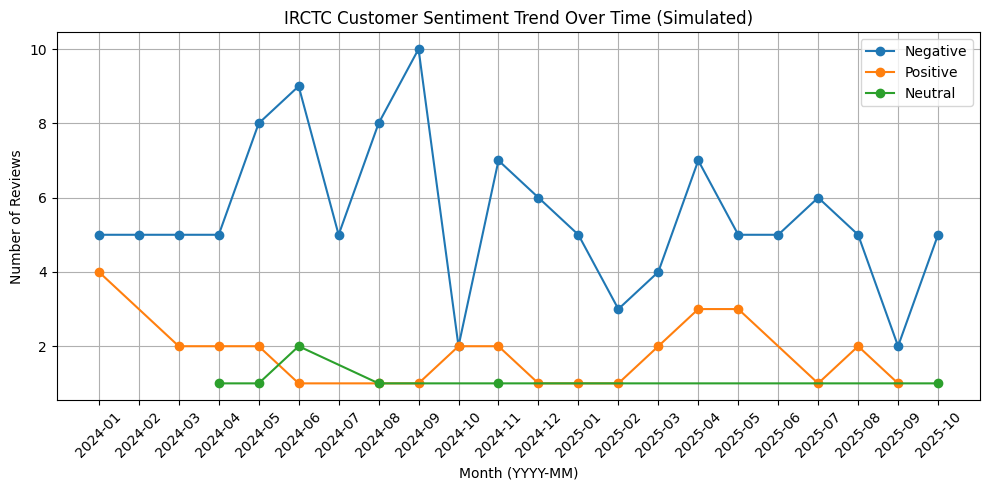

In [0]:
# ------------------------------------------------------------
# 📊 Step 8: Visualize Monthly Sentiment Trends
# ------------------------------------------------------------
plt.figure(figsize=(10,5))
for sentiment in trend_pd["Sentiment"].unique():
    subset = trend_pd[trend_pd["Sentiment"] == sentiment]
    plt.plot(subset["month"], subset["count"], marker="o", label=sentiment)

plt.title("IRCTC Customer Sentiment Trend Over Time (Simulated)")
plt.xlabel("Month (YYYY-MM)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
# ------------------------------------------------------------
# 🔍 Step 9: Insights Summary
# ------------------------------------------------------------
latest_month = trend_pd["month"].max()
latest = trend_pd[trend_pd["month"] == latest_month]

print("\n🔍 Insights Summary:")
print(f"Latest Month: {latest_month}")
for _, row in latest.iterrows():
    print(f"{row['Sentiment']}: {row['count']} reviews")

print("\n✅ Use Case 3 executed successfully — Time-Based Sentiment Trend Analysis completed!")



🔍 Insights Summary:
Latest Month: 2025-10
Neutral: 1 reviews
Negative: 5 reviews

✅ Use Case 3 executed successfully — Time-Based Sentiment Trend Analysis completed!


In [0]:
# ------------------------------------------------------------
# 💾 Step 10: Save Monthly Sentiment Trends
# ------------------------------------------------------------
output_df = predictions.select("review", "date", "label")
output_path = "/Workspace/exports/IRCTC_Time_Based_Sentiment_Trend.csv"
output_df.toPandas().to_csv(output_path, index=False)
print(f"📁 Sentiment trend results saved at: {output_path}")

📁 Sentiment trend results saved at: /Workspace/exports/IRCTC_Time_Based_Sentiment_Trend.csv
